In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

sparkConf = SparkConf()
sparkConf.setMaster("local[*]")
sparkConf.setAppName("data_exploration_with_ros_hadoop")
sparkConf.set("spark.jars", "../lib/protobuf-java-3.3.0.jar,../lib/rosbaginputformat.jar,../lib/scala-library-2.11.8.jar")

spark = SparkSession.builder.config(conf=sparkConf).getOrCreate()
sc = spark.sparkContext

## Create an RDD from the Rosbag file
**Note:** your HDFS address might differ.

In [2]:
fin = sc.newAPIHadoopFile(
    path =             "hdfs://127.0.0.1:9000/user/root/HMB_4.bag",
    inputFormatClass = "de.valtech.foss.RosbagMapInputFormat",
    keyClass =         "org.apache.hadoop.io.LongWritable",
    valueClass =       "org.apache.hadoop.io.MapWritable",
    conf =             {"RosbagInputFormat.chunkIdx":"/opt/ros_hadoop/master/dist/HMB_4.bag.idx.bin"})

## Interpret the Messages
To interpret the messages we need the connections.

We could get the connections as configuration as well. At the moment we decided to collect the connections into Spark driver in a dictionary and use it in the subsequent RDD actions. Note in the next version of the RosbagInputFormater alternative implementations will be given.

### Collect the connections from all Spark partitions of the bag file into the Spark driver

In [3]:
conn_a = fin.filter(lambda r: r[1]['header']['op'] == 7).map(lambda r: r[1]).collect()
conn_d = {str(k['header']['topic']):k for k in conn_a}
# see topic names
conn_d.keys()

['/right_camera/camera_info',
 '/fix',
 '/center_camera/image_color/compressed',
 '/ecef/',
 '/vehicle/steering_report',
 '/vehicle/brake_report',
 '/pressure',
 '/vehicle/gps/time',
 '/vehicle/joint_states',
 '/vehicle/suspension_report',
 '/vehicle/sonar_cloud',
 '/velodyne_packets',
 '/vehicle/surround_report',
 '/diagnostics',
 '/vehicle/brake_info_report',
 '/vehicle/imu/data_raw',
 '/time_reference',
 '/vehicle/gear_report',
 '/vehicle/throttle_report',
 '/vehicle/fuel_level_report',
 '/vehicle/gps/vel',
 '/imu/data',
 '/center_camera/camera_info',
 '/vehicle/filtered_accel',
 '/vehicle/wheel_speed_report',
 '/vehicle/twist_controller/parameter_descriptions',
 '/left_camera/image_color/compressed',
 '/can_bus_dbw/can_rx',
 '/vehicle/twist_controller/parameter_updates',
 '/vehicle/throttle_info_report',
 '/right_camera/image_color/compressed',
 '/vehicle/misc_1_report',
 '/vehicle/gps/fix',
 '/vehicle/tire_pressure_report',
 '/left_camera/camera_info',
 '/vehicle/dbw_enabled']

### Load the python map functions from src/main/python/functions.py

In [4]:
%run -i ../src/main/python/functions.py

### Use of msg_map to apply a function on all messages
Python **rosbag.bag** needs to be installed on all Spark workers.
The msg_map function (from src/main/python/functions.py) takes three arguments:
1. r = the message or RDD record Tuple
2. func = a function (default str) to apply to the ROS message
3. conn = a connection to specify what topic to process


In [5]:
%matplotlib inline 
# use %matplotlib notebook in python3
from functools import partial
import pandas as pd
import numpy as np

### Aggregate acceleration statistics

In [6]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
from pyspark.sql import types as T
import yaml
sns.set_style('whitegrid')
sns.set_context('talk')

In [7]:
schema = T.StructType()
schema = schema.add(T.StructField('seq',T.IntegerType()))
schema = schema.add(T.StructField('secs',T.IntegerType()))
schema = schema.add(T.StructField('nsecs',T.IntegerType()))
schema = schema.add(T.StructField('orientation_x',T.DoubleType()))
schema = schema.add(T.StructField('orientation_y',T.DoubleType()))
schema = schema.add(T.StructField('orientation_z',T.DoubleType()))
schema = schema.add(T.StructField('angular_velocity_x',T.DoubleType()))
schema = schema.add(T.StructField('angular_velocity_y',T.DoubleType()))
schema = schema.add(T.StructField('angular_velocity_z',T.DoubleType()))
schema = schema.add(T.StructField('linear_acceleration_x',T.DoubleType()))
schema = schema.add(T.StructField('linear_acceleration_y',T.DoubleType()))
schema = schema.add(T.StructField('linear_acceleration_z',T.DoubleType()))

def get_time_and_acc(r):
    return (r.header.seq,
            r.header.stamp.secs,
            r.header.stamp.nsecs,
            r.orientation.x,
            r.orientation.y,
            r.orientation.z,
            r.angular_velocity.x,
            r.angular_velocity.y,
            r.angular_velocity.z,
            r.linear_acceleration.x,
            r.linear_acceleration.y,
            r.linear_acceleration.z,
           )

pdf_acc = spark.createDataFrame(fin
                             .flatMap(partial(msg_map, func=get_time_and_acc, conn=conn_d['/imu/data'])),
                             schema=schema).toPandas()
pdf_acc.head()

,seq,secs,nsecs,orientation_x,orientation_y,orientation_z,angular_velocity_x,angular_velocity_y,angular_velocity_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z
0,1701626,1479425728,747487068,-0.025143,0.028464,-0.093654,0.0,0.0,0.0,1.160419,0.595418,10.756533
1,1701627,1479425728,750332117,-0.025204,0.028431,-0.093677,0.0,0.0,0.0,0.946552,0.521104,11.197094
2,1701628,1479425728,751904010,-0.025233,0.028396,-0.093676,0.0,0.0,0.0,0.726597,0.395636,11.612808
3,1701629,1479425728,753854990,-0.025238,0.028357,-0.093686,0.0,0.0,0.0,0.493483,0.521169,11.860813
4,1701630,1479425728,754970073,-0.025229,0.028320,-0.093705,0.0,0.0,0.0,0.381820,0.490791,11.686852


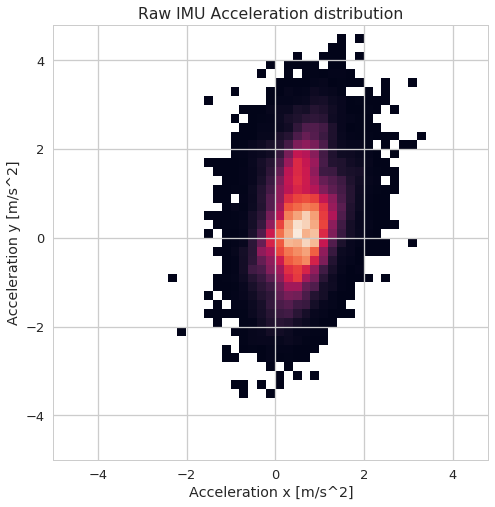

In [8]:
xbins = np.arange(-5,5,0.2)
ybins = np.arange(-5,5,0.2)

h,_,_ = np.histogram2d(pdf_acc.linear_acceleration_x,pdf_acc.linear_acceleration_y, bins=(xbins,ybins))
h[h == 0] = np.NaN

fig, ax = plt.subplots(figsize=(10,8))
plt.imshow(h.T,extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],origin='lower',interpolation='nearest')
#plt.colorbar()
plt.xlabel(r'Acceleration x [m/s^2]')
plt.ylabel('Acceleration y [m/s^2]')
plt.title('Raw IMU Acceleration distribution');

### Visualize track in Google maps

You have to apply for an Google Maps API key to execute this section, cf.
https://developers.google.com/maps/documentation/javascript/get-api-key

Add your key to the next cell:

In [9]:
import gmaps
gmaps.configure('AI...')

In [10]:
schema = T.StructType()
schema = schema.add(T.StructField('seq',T.IntegerType()))
schema = schema.add(T.StructField('secs',T.IntegerType()))
schema = schema.add(T.StructField('nsecs',T.IntegerType()))
schema = schema.add(T.StructField('latitude',T.DoubleType()))
schema = schema.add(T.StructField('longitude',T.DoubleType()))
schema = schema.add(T.StructField('altitude',T.DoubleType()))
schema = schema.add(T.StructField('status_service',T.IntegerType()))
schema = schema.add(T.StructField('status_status',T.IntegerType()))


def get_gps(r):
    return (r.header.seq,
            r.header.stamp.secs,
            r.header.stamp.nsecs,
            r.latitude,
            r.longitude,
            r.altitude,
            r.status.service,
            r.status.status
           )

pdf_gps = spark.createDataFrame(
    fin
    .flatMap(partial(msg_map, func=get_gps, conn=conn_d['/vehicle/gps/fix'])),
    schema=schema
).toPandas()

pdf_gps.head()

,seq,secs,nsecs,latitude,longitude,altitude,status_service,status_status
0,7097,1479425729,563822067,37.492877,-122.382496,6.0,1,0
1,7098,1479425730,574133751,37.492912,-122.382251,6.0,1,0
2,7099,1479425731,563593839,37.492949,-122.381995,6.0,1,0
3,7100,1479425732,563785775,37.492984,-122.381749,6.0,1,0
4,7101,1479425733,563699605,37.493019,-122.381504,6.0,1,0


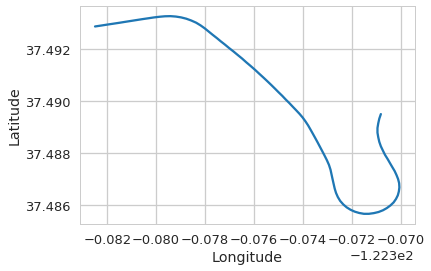

In [11]:
fig, ax = plt.subplots()
pdf_gps.sort_values('secs').plot('longitude','latitude',ax=ax, legend=False)
plt.xlabel('Longitude')
plt.ylabel('Latitude');

In [12]:
c='rgba(0,0,150,0.3)'

fig = gmaps.figure(center=(pdf_gps.latitude.mean(),pdf_gps.longitude.mean()), zoom_level=14)
track = gmaps.symbol_layer(pdf_gps[['latitude','longitude']], fill_color=c, stroke_color=c, scale=2)
fig.add_layer(track)
fig

Figure(layout=FigureLayout(height=u'420px'))

Output of this cell would look like this
![](./map.png)

### Steering angle and speed

In [13]:
from pyspark.sql import Row
from datetime import datetime

In [14]:
pdf_steering = spark.createDataFrame(fin.flatMap(partial(msg_map, func=lambda r: Row(**yaml.load(str(r))), conn=conn_d['/vehicle/steering_report']))).toPandas()
pdf_steering['secs'] = pdf_steering.header.map(lambda r: r['stamp']['secs']+r['stamp']['nsecs']*1e-9 )
pdf_steering = pdf_steering.set_index(pdf_steering.secs.map(datetime.fromtimestamp))
pdf_steering.head()

,driver,enabled,fault_bus1,fault_bus2,fault_calibration,fault_connector,fault_wdc,header,override,speed,steering_wheel_angle,steering_wheel_angle_cmd,steering_wheel_torque,secs
secs,,,,,,,,,,,,,,
2016-11-17 23:35:28.762169,False,False,False,False,False,True,False,"{u'stamp': {u'secs': 1479425728, u'nsecs': 762...",False,22.505556,0.026180,0.0,0.1875,1.479426e+09
2016-11-17 23:35:28.782174,False,False,False,False,False,True,False,"{u'stamp': {u'secs': 1479425728, u'nsecs': 782...",False,22.508333,0.026180,0.0,0.2500,1.479426e+09
2016-11-17 23:35:28.802231,False,False,False,False,False,True,False,"{u'stamp': {u'secs': 1479425728, u'nsecs': 802...",False,22.508333,0.024435,0.0,0.3125,1.479426e+09
2016-11-17 23:35:28.822261,False,False,False,False,False,True,False,"{u'stamp': {u'secs': 1479425728, u'nsecs': 822...",False,22.505556,0.024435,0.0,0.3750,1.479426e+09
2016-11-17 23:35:28.842307,False,False,False,False,False,True,False,"{u'stamp': {u'secs': 1479425728, u'nsecs': 842...",False,22.500000,0.024435,0.0,0.3750,1.479426e+09


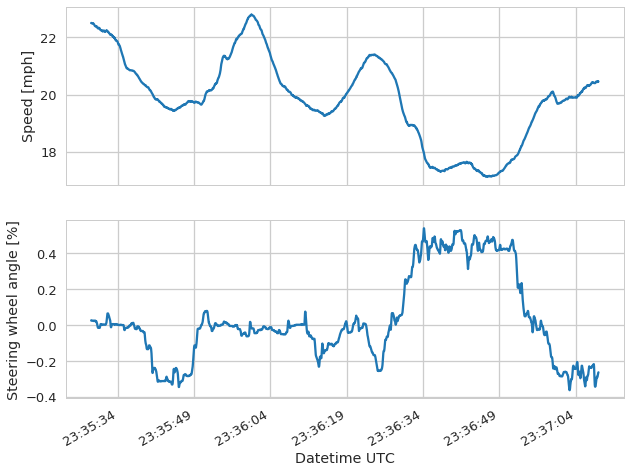

In [15]:
fig, axes = plt.subplots(2,1,figsize=(10,8))
pdf_steering.speed.plot(ax=axes[0])
pdf_steering.steering_wheel_angle.plot(ax=axes[1])

axes[0].set_xlabel('')
axes[0].set_ylabel('Speed [mph]')
axes[0].set_xticklabels('')
axes[1].set_xlabel('Datetime UTC')
axes[1].set_ylabel('Steering wheel angle [%]');

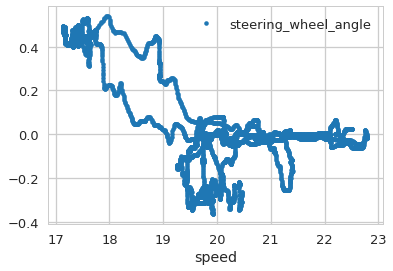

In [16]:
pdf_steering.plot('speed','steering_wheel_angle',style='.');

### Machine Learning models on Spark workers
A dot product Keras "model" for each message from a topic. We will compare it with the one computed with numpy.

**Note** that the imports happen in the workers and not in driver. On the other hand the connection dictionary is sent over the closure.

In [17]:
def f(msg):
    from keras.layers import dot, Dot, Input
    from keras.models import Model
    
    linear_acceleration = {
        'x': msg.linear_acceleration.x,
        'y': msg.linear_acceleration.y,
        'z': msg.linear_acceleration.z,
    }
    
    linear_acceleration_covariance = np.array(msg.linear_acceleration_covariance)
    
    i1 = Input(shape=(3,))
    i2 = Input(shape=(3,))
    o = dot([i1,i2], axes=1)
    
    model = Model([i1,i2], o)
    
    # return a tuple with (numpy dot product, keras dot "predict")
    return (
        np.dot(linear_acceleration_covariance.reshape(3,3), 
               [linear_acceleration['x'], linear_acceleration['y'], linear_acceleration['z']]),
        model.predict([
            np.array([[ linear_acceleration['x'], linear_acceleration['y'], linear_acceleration['z'] ]]),
            linear_acceleration_covariance.reshape((3,3))])
    )

fin.flatMap(partial(msg_map, func=f, conn=conn_d['/vehicle/imu/data_raw'])).take(5)

# tuple with (numpy dot product, keras dot "predict")

[(array([-0.07,  0.  ,  0.  ]), array([[-0.07]], dtype=float32)),
 (array([-0.06,  0.  ,  0.  ]), array([[-0.06]], dtype=float32)),
 (array([-0.04,  0.  ,  0.  ]), array([[-0.04]], dtype=float32)),
 (array([-0.05,  0.  ,  0.  ]), array([[-0.05]], dtype=float32)),
 (array([-0.09,  0.  ,  0.  ]), array([[-0.09]], dtype=float32))]

One can of course sample and collect the data in the driver to train a model.

Note that the msg is the most granular unit but you could of course replace the flatMap with a **mapPartitions**

Another option would be to have a map.reduceByKey before the flatMap so that the function argument would be a whole interval instead of a msg.